In [1]:
#!/usr/bin/env python

# dBZ-height_DisplacementBasedEvaluation.ipynb

    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.01.2021
    Date last modified: 26.01.2021
        
    ##############################################################
    Purpos:
    
    Needs preprocessed data from:
    projects/2019_ASR-MCS/programs/DisplacementBasedEvaluation/DisplacementBasedEvaluation.py

    1) Read in preprocessed datasets
    2) Plot heatmaps showing the skill of different model settings for different statistics

In [2]:
from dateutil import rrule
import datetime
from datetime import timedelta
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
import shapely.geometry
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Polygon, Point
from scipy.interpolate import interp1d
import csv
import os.path
import matplotlib.path as mplPath
from scipy import stats
from cartopy import config
import cartopy.crs as ccrs
import cartopy
from cartopy.feature import NaturalEarthFeature
import cartopy.io.shapereader as shpreader
from shutil import copyfile
from matplotlib import path
# from mpl_toolkits.basemap import Basemap; bm = Basemap()
from scipy.interpolate import interp1d
import scipy
import seaborn as sns
from scipy import signal
# from netcdftime import utime
import scipy
from scipy.stats import pearsonr
from scipy import signal
from cartopy.io.shapereader import Reader
from scipy.stats import chisquare
from scipy import signal
from calendar import monthrange
from scipy import interpolate
from scipy.interpolate import griddata
import scipy.stats as ss
import pandas as pd
import scipy.stats as ss


# coordinate distance
def CORD_Dist(Lon1,Lat1,Lon2,Lat2):
    from math import sin, cos, sqrt, atan2, radians

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(Lat1)
    lon1 = radians(Lon1)
    lat2 = radians(Lat2)
    lon2 = radians(Lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

### User input section

In [3]:
# Datasets
OutputFolder='/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/DisplacementBasedEvaluation/' 
GridSpacing=['4km']

TempDicpl=float(4) # +- search window in hours arround time of peak dBZ observatio
SpatialDispl=float(2) # +- search windown in degrees for spatial displacement
DeltaDeg=float(2.6) # radius of radar scan in degrees;  4.3 deg is maximum!
Zlevel=int(2) # dBZ height of scan in km  [2,4,6]

Setting = 'dBZ'+str(Zlevel)+'km_dt'+str(TempDicpl)+'h_dx'+str(SpatialDispl)+'deg_RadarReach'+str(DeltaDeg)+'deg'


sPlotDir = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/plots/DisplacementBasedEvaluation/'
rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

# SimulationsAll = [  'mao_20140319_09:00:00_L4','mao_20140320_11:00:00_L4','mao_20140323_18:00:00_L4','mao_20140331_06:00:00_L4',
#                     'mao_20140401_15:00:00_L4','mao_20140414_07:00:00_L4','mao_20140421_07:00:00_L4','mao_20140509_12:00:00_L4',
#                     'mao_20140616_18:00:00_L4','mao_20140619_14:00:00_L4','mao_20140703_10:00:00_L4','mao_20140709_15:00:00_L4', 
#                     'mao_20140712_17:00:00_L4','mao_20140816_14:00:00_L4','mao_20140917_17:00:00_L4','mao_20141004_13:00:00_L4' ,
#                     'mao_20141015_08:00:00_L4','mao_20141016_13:00:00_L4','mao_20141018_14:00:00_L4','mao_20141109_14:00:00_L4' ,
#                     'mao_20141117_18:00:00_L4','mao_20141120_10:00:00_L4','mao_20141127_13:00:00_L4','mao_20141210_14:00:00_L4' ,
#                     'mao_20141211_11:00:00_L4','mao_20141214_15:00:00_L4','mao_20150109_11:00:00_L4','mao_20150110_13:00:00_L4' ,
#                     'mao_20150111_14:00:00_L4','mao_20150119_19:00:00_L4','mao_20150222_18:00:00_L4','mao_20150303_20:00:00_L4' ,
#                     'mao_20150311_11:00:00_L4','mao_20150328_15:00:00_L4','mao_20150329_16:00:00_L4','mao_20150331_13:00:00_L4' ,
#                     'mao_20150412_12:00:00_L4','mao_20150425_15:00:00_L4','mao_20150607_16:00:00_L4','mao_20150621_14:00:00_L4' ,
#                     'mao_20151106_12:00:00_L4','mao_20151126_07:00:00_L4','sgp_20120531_04:00:00_L4','sgp_20120615_07:00:00_L4' ,
#                     'sgp_20130509_07:00:00_L4','sgp_20130605_09:00:00_L4','sgp_20130617_07:00:00_L4','sgp_20140602_04:00:00_L4' ,
#                     'sgp_20140605_12:00:00_L4','sgp_20140612_06:00:00_L4','sgp_20140628_16:00:00_L4','sgp_20140710_10:00:00_L4' ,
#                     'sgp_20160308_15:00:00_L4','sgp_20160618_10:00:00_L4','sgp_20160729_09:00:00_L4']

SimulationsAll = [  'mao_20140816_14:00:00_L4', 'mao_20140917_17:00:00_L4', 'mao_20150621_14:00:00_L4','mao_20140401_15:00:00_L4',\
                    'mao_20141210_14:00:00_L4', 'mao_20150328_15:00:00_L4', 'mao_20150412_12:00:00_L4', 'mao_20141004_13:00:00_L4',\
                    'mao_20141018_14:00:00_L4', 'mao_20141117_18:00:00_L4', 'mao_20151106_12:00:00_L4','mao_average', 'mao_',
                    'sgp_20120531_04:00:00_L4','sgp_20120615_07:00:00_L4' , 
                    'sgp_20130509_07:00:00_L4','sgp_20130605_09:00:00_L4','sgp_20130617_07:00:00_L4','sgp_20140602_04:00:00_L4' ,
                    'sgp_20140605_12:00:00_L4','sgp_20140612_06:00:00_L4','sgp_20140628_16:00:00_L4','sgp_20140710_10:00:00_L4' ,
                    'sgp_20160308_15:00:00_L4','sgp_20160618_10:00:00_L4','sgp_20160729_09:00:00_L4','sgp_average']

Physics = ['Thomson_YSU','Thomson_MYJ','Thomson_MYNN2.5','Morrison_YSU','Morrison_MYJ','Morrison_MYNN2.5','P351_YSU','P351_MYJ','P351_MYNN2.5']
PH_short = ['T-YSU','T-MYJ','T-MYNN2.5','M-YSU','M-MYJ','M-MYNN2.5','P-YSU','P-MYJ','P-MYNN2.5']

SelectedCases = ['mao_20140816_14:00:00_L4', 'mao_20140917_17:00:00_L4', 'mao_20150621_14:00:00_L4','mao_20140401_15:00:00_L4',\
                 'mao_20141210_14:00:00_L4', 'mao_20150328_15:00:00_L4', 'mao_20150412_12:00:00_L4', 'mao_20141004_13:00:00_L4',\
                 'mao_20141018_14:00:00_L4', 'mao_20141117_18:00:00_L4', 'mao_20151106_12:00:00_L4'] #,'sgp_20120615_07:00:00_L4' ,
#                 'sgp_20130509_07:00:00_L4','sgp_20130605_09:00:00_L4','sgp_20130617_07:00:00_L4','sgp_20140602_04:00:00_L4' ,
#                 'sgp_20140605_12:00:00_L4','sgp_20140612_06:00:00_L4','sgp_20140628_16:00:00_L4','sgp_20140710_10:00:00_L4' ,
#                 'sgp_20160308_15:00:00_L4','sgp_20160618_10:00:00_L4','sgp_20160729_09:00:00_L4']

iSel = np.isin(SimulationsAll, SelectedCases)
SGP = [SimulationsAll[si][:3] == 'sgp' for si in range(len(SimulationsAll))]
MAO = [SimulationsAll[si][:3] == 'mao' for si in range(len(SimulationsAll))]
MAOsel = np.isin(SimulationsAll, SelectedCases)


In [4]:
SimShort = [SimulationsAll[si].split('_')[0]+'_'+SimulationsAll[si].split('_')[1]+'_'+SimulationsAll[si].split('_')[-1] for si in range(len(SimulationsAll))]

### Load the preprocessed data

In [5]:
T_DISPL = np.zeros((len(Physics),len(SimulationsAll))); T_DISPL[:] = np.nan
XY_DISPL = np.copy(T_DISPL)
BT_CORR = np.copy(T_DISPL)
dBZ_CORR = np.copy(T_DISPL)
BT_CDF = np.copy(T_DISPL)
dBZ_CDF = np.copy(T_DISPL)


Best_Time = []
Experiment = []
Best_Lat = []
Best_Lon = []
T_displace = []

for ph in range(len(Physics)):
    for si in range(len(SimulationsAll)):
        ProcessFile = OutputFolder+Physics[ph]+'_'+SimulationsAll[si]+'_'+Setting+'.npz'
        if os.path.isfile(ProcessFile):
            DATA = np.load(ProcessFile, allow_pickle=True)
            if (ph == 0) & (si == 0):
                SHAPE = np.array(DATA['BT_focus_Area'][0]).shape
                dBZ_FocArea = np.zeros((len(Physics),len(SimulationsAll),2,SHAPE[0],SHAPE[1])); dBZ_FocArea[:] = np.nan
                BT_FocArea = np.copy(dBZ_FocArea)
                xyMIN = np.min([np.array(DATA['BT_focus_Area'][0]).shape[0], np.array(DATA['BT_focus_Area'][1]).shape[1]])-1
            try:
                BT_tmp = DATA['BT_focus_Area']
                BT_FocArea[ph,si,0,:xyMIN,:xyMIN] = BT_tmp[0][:xyMIN,:xyMIN]
                BT_FocArea[ph,si,1,:xyMIN,:xyMIN] = BT_tmp[1][:xyMIN,:xyMIN]

                dBZ_tmp = DATA['dBZ_focus_Area']
                dBZ_FocArea[ph,si,0,:xyMIN,:xyMIN] = dBZ_tmp[0][:xyMIN,:xyMIN]
                dBZ_FocArea[ph,si,1,:xyMIN,:xyMIN] = dBZ_tmp[1][:xyMIN,:xyMIN]
            except:
                print('    Missing '+ProcessFile)

            Scores = list(DATA['Score_Names'])
            Values = DATA['Score_Values']
            T_DISPL[ph,si] = Values[Scores.index('Delta t [min]')]
            XY_DISPL[ph,si] = Values[Scores.index('Delta loc [km]')]
            BT_CORR[ph,si] = Values[Scores.index('BT CC []')]
            dBZ_CORR[ph,si] = Values[Scores.index('dBZ CC []')]
            BT_CDF[ph,si] = Values[Scores.index('BT CDF diff. [K]')]
            dBZ_CDF[ph,si] = Values[-1]

            try:
                Delta_Time = pd.to_datetime(DATA['WRFtime'][np.nanargmax(np.nanmax(DATA['Displacement'], axis=(1,2)))])
                MaxField = DATA['Displacement'][np.nanargmax(np.nanmax(DATA['Displacement'], axis=(1,2))),:,:]
                Lon = DATA['Lon']
                Lat = DATA['Lat']
                
                MIN = np.where(MaxField == np.nanmax(MaxField))
                iLatMIN = MIN[0][0] #iARM[0][0]+MIN[0][0]-int(Displacement.shape[1]/2)
                iLonMIN = MIN[1][0] #iARM[1][0]+MIN[1][0]-int(Displacement.shape[2]/2)
                Best_Lat = Best_Lat + [Lat[iLatMIN,iLonMIN]]
                Best_Lon = Best_Lon + [Lon[iLatMIN,iLonMIN]]
                Best_Time = Best_Time + [Delta_Time]
                Experiment = Experiment + [Physics[ph]+'_'+SimulationsAll[si]]
                T_displace = T_displace + [T_DISPL[ph,si]]
            except:
                print('    Missing '+ProcessFile)
                
df = pd.DataFrame({'Experiment': Experiment,
                   'Best_Time': Best_Time,
                   'Best_Lon': Best_Lon,
                   'Best_Lat': Best_Lat,
                   'Temporal_Displacement_minutes':T_displace})
df.to_csv('Optimal_Location_ARM-MCSs.csv' ,index=False)

### calcualte the average for each region

In [6]:
dBZ_CORR[:,11] = np.nanmean(dBZ_CORR[:,MAO][:,:-2], axis=1)
dBZ_CORR[:,-1] = np.nanmean(dBZ_CORR[:,SGP][:,:-1], axis=1)

BT_CORR[:,11] = np.nanmean(BT_CORR[:,MAO][:,:-2], axis=1)
BT_CORR[:,-1] = np.nanmean(BT_CORR[:,SGP][:,:-1], axis=1)

dBZ_CDF[:,11] = np.nanmean(dBZ_CDF[:,MAO][:,:-2], axis=1)
dBZ_CDF[:,-1] = np.nanmean(dBZ_CDF[:,SGP][:,:-1], axis=1)

BT_CDF[:,11] = np.nanmean(BT_CDF[:,MAO][:,:-2], axis=1)
BT_CDF[:,-1] = np.nanmean(BT_CDF[:,SGP][:,:-1], axis=1)

T_DISPL[:,11] = np.nanmean(T_DISPL[:,MAO][:,:-2], axis=1)
T_DISPL[:,-1] = np.nanmean(T_DISPL[:,SGP][:,:-1], axis=1)

XY_DISPL[:,11] = np.nanmean(XY_DISPL[:,MAO][:,:-2], axis=1)
XY_DISPL[:,-1] = np.nanmean(XY_DISPL[:,SGP][:,:-1], axis=1)

### Start Plotting

In [7]:
SimShort = np.array(SimShort)
SimShort[SimShort == 'mao_average_average'] = 'mao_average'
SimShort[SimShort == 'mao__'] = ' '
SimShort[SimShort == 'sgp_average_average'] = 'sgp_average'

        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/plots/DisplacementBasedEvaluation/Skill-Overview_dx4km_Heatmap.pdf


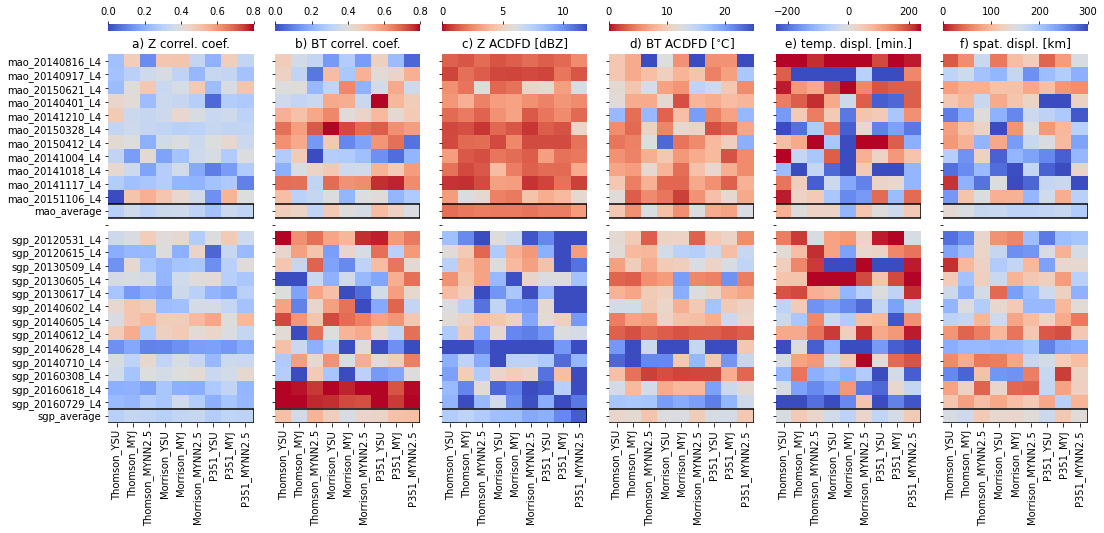

In [8]:
fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 10})
MA = np.where(SimShort == 'mao_average')[0][0]
SG = np.where(SimShort == 'sgp_average')[0][0]

# CORRELATIONS
gs2 = gridspec.GridSpec(ncols=6, nrows=1, figure=fig)
gs2.update(left=0.10, right=0.95,
           bottom=0.20, top=1,
           wspace=0.15, hspace=0.2)

# corr for dBZ
ax = fig.add_subplot(gs2[0,0])
ax=sns.heatmap(dBZ_CORR.T, cmap='coolwarm', vmin=0, vmax=0.8, cbar_kws = dict(use_gridspec=False,location="top"))

ax.set_yticklabels(SimShort, rotation=0)
ax.set_xticklabels(Physics, rotation=90)
plt.title(rgsLableABC[0]+') Z correl. coef.')
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')

# corr for BT
ax = fig.add_subplot(gs2[0,1])
ax=sns.heatmap(BT_CORR.T, cmap='coolwarm', vmin=0, vmax=0.8, cbar_kws = dict(use_gridspec=False,location="top"))
plt.title(rgsLableABC[1]+') BT correl. coef.')
ax.set_xticklabels(Physics, rotation=90)
ax.set_yticklabels(['']*len(SimShort), rotation=0)
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')


# CDF ERROR dbz

# cdf for dBZ
ax = fig.add_subplot(gs2[0,2])
ax=sns.heatmap(dBZ_CDF.T, cmap='coolwarm_r', vmin=0, vmax=12, cbar_kws = dict(use_gridspec=False,location="top"))

ax.set_xticklabels(Physics, rotation=90)
ax.set_yticklabels(['']*len(SimShort), rotation=0)
plt.title(rgsLableABC[2]+') Z ACDFD [dBZ]')
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')


# CDF ERROR BT

# cdf for dBZ
ax = fig.add_subplot(gs2[0,3])
ax=sns.heatmap(BT_CDF.T, cmap='coolwarm_r', vmin=0, vmax=25, cbar_kws = dict(use_gridspec=False,location="top"))

ax.set_xticklabels(Physics, rotation=90)
ax.set_yticklabels(['']*len(SimShort), rotation=0)
plt.title(rgsLableABC[3]+') BT ACDFD [$^{\circ}$C]')
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')


# T displacement
ax = fig.add_subplot(gs2[0,4])
ax=sns.heatmap(T_DISPL.T, cmap='coolwarm', vmin=-240, vmax=240, cbar_kws = dict(use_gridspec=False,location="top"))

ax.set_xticklabels(Physics, rotation=90)
ax.set_yticklabels(['']*len(SimShort), rotation=0)
plt.title(rgsLableABC[4]+') temp. displ. [min.]')
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')


# XY displacement
ax = fig.add_subplot(gs2[0,5])
ax=sns.heatmap(XY_DISPL.T, cmap='coolwarm_r', vmin=0, vmax=300, cbar_kws = dict(use_gridspec=False,location="top"))

ax.set_xticklabels(Physics, rotation=90)
ax.set_yticklabels(['']*len(SimShort), rotation=0)
plt.title(rgsLableABC[5]+') spat. displ. [km]')
plt.plot([0,9,9,0],[MA,MA,MA+1,MA+1], c='k')
plt.plot([0,9,9,0],[SG,SG,SG+1,SG+1], c='k')
    

# Save the plot
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
sPlotName= 'Skill-Overview_dx'+GridSpacing[0]+'_Heatmap.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Overview Plot

        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/plots/DisplacementBasedEvaluation/DisplacementBasedEvaluation_overview.pdf


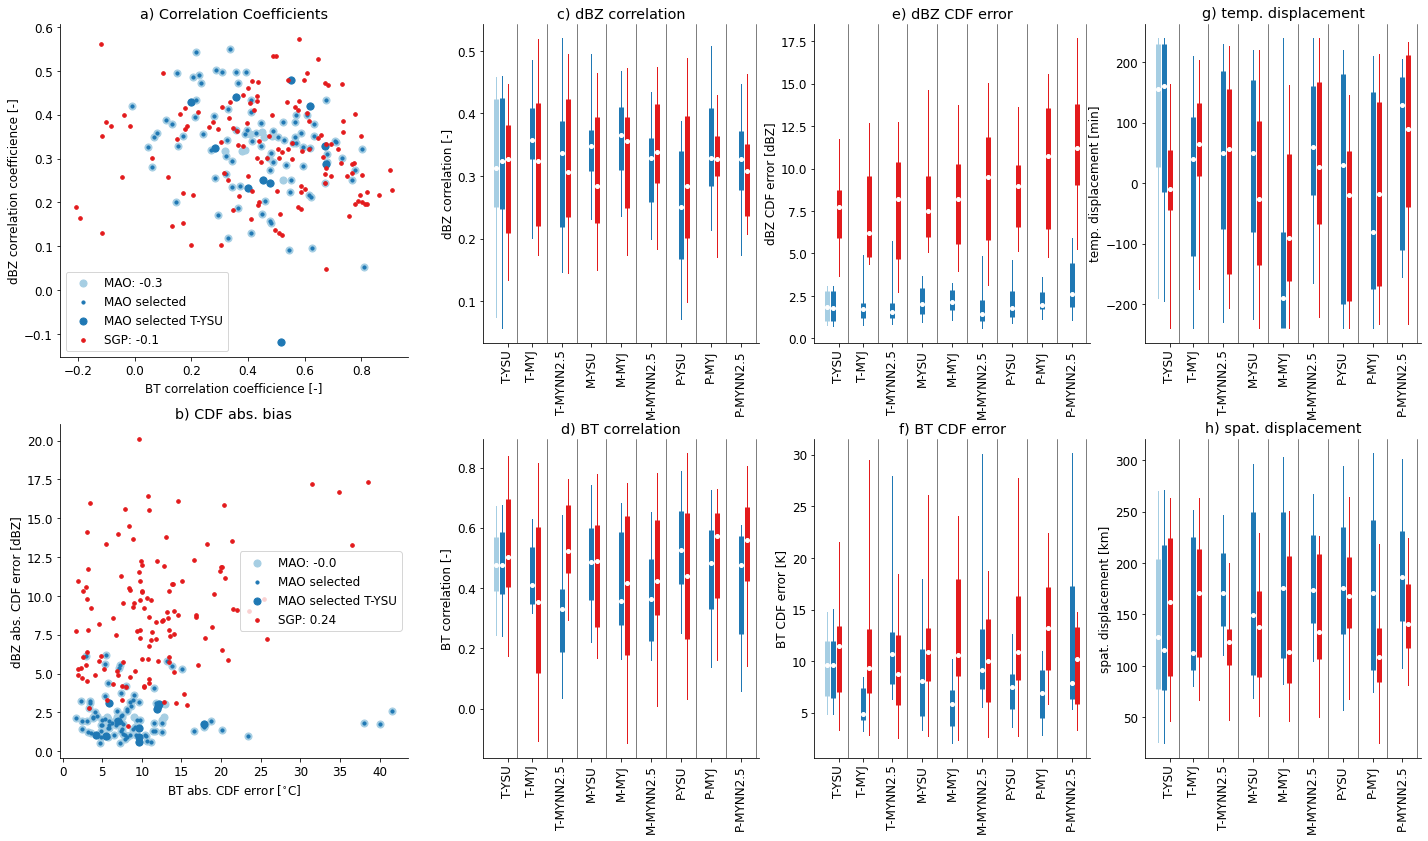

In [9]:
fig = plt.figure(figsize=(21, 12))
plt.rcParams.update({'font.size': 12})

# =======================
# Scatter plots and correlation coefficients
gs2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
gs2.update(left=0.07, right=0.3,
           bottom=0.1, top=0.95,
           wspace=0.05, hspace=0.2)

# Spatial correlation
ax = fig.add_subplot(gs2[0,0])
FIN = ~np.isnan(BT_CORR[:,MAO].flatten())
CORR_MAO = scipy.stats.spearmanr(BT_CORR[:,MAO].flatten()[FIN],dBZ_CORR[:,MAO].flatten()[FIN])[0]
plt.scatter(BT_CORR[:,MAO],dBZ_CORR[:,MAO], c='#a6cee3', s=50, label='MAO: '+str(CORR_MAO)[:4])
plt.scatter(BT_CORR[:,iSel],dBZ_CORR[:,iSel], c='#1f78b4', s=10, label='MAO selected')
plt.scatter(BT_CORR[0,iSel],dBZ_CORR[0,iSel], c='#1f78b4', s=50, label='MAO selected T-YSU')

FIN = ~np.isnan(BT_CORR[:,SGP].flatten())
CORR_SGP = scipy.stats.spearmanr(BT_CORR[:,SGP].flatten()[FIN],dBZ_CORR[:,SGP].flatten()[FIN])[0]
plt.scatter(BT_CORR[:,SGP],dBZ_CORR[:,SGP], c='#e31a1c', s=13, label='SGP: '+str(CORR_SGP)[:4])
plt.legend()

ax.set_xlabel('BT correlation coefficience [-]')
ax.set_ylabel('dBZ correlation coefficience [-]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(rgsLableABC[0]+') Correlation Coefficients')

# =======================
# Scatter plots for CDF diff.

# Spatial correlation
ax = fig.add_subplot(gs2[1,0])
FIN = ~np.isnan(BT_CDF[:,MAO].flatten())
CDF_MAO = scipy.stats.spearmanr(BT_CDF[:,MAO].flatten()[FIN],dBZ_CDF[:,MAO].flatten()[FIN])[0]
plt.scatter(BT_CDF[:,MAO],dBZ_CDF[:,MAO], c='#a6cee3', s=50, label='MAO: '+str(CDF_MAO)[:4])
plt.scatter(BT_CDF[:,iSel],dBZ_CDF[:,iSel], c='#1f78b4', s=10, label='MAO selected')
plt.scatter(BT_CDF[0,iSel],dBZ_CDF[0,iSel], c='#1f78b4', s=50, label='MAO selected T-YSU')


FIN = ~np.isnan(BT_CDF[:,SGP].flatten())
CDF_SGP = scipy.stats.spearmanr(BT_CDF[:,SGP].flatten()[FIN],dBZ_CDF[:,SGP].flatten()[FIN])[0]
plt.scatter(BT_CDF[:,SGP],dBZ_CDF[:,SGP], c='#e31a1c', s=13, label='SGP: '+str(CDF_SGP)[:4])
plt.legend()

ax.set_xlabel('BT abs. CDF error [$^{\circ}$C]')
ax.set_ylabel('dBZ abs. CDF error [dBZ]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(rgsLableABC[1]+') CDF abs. bias')


# =======================
# Box-whisker plots for different statistics
gs2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
gs2.update(left=0.35, right=0.97,
           bottom=0.1, top=0.95,
           wspace=0.2, hspace=0.3)

STATS = ['dBZ correlation','BT correlation','dBZ CDF error','BT CDF error','temp. displacement','spat. displacement']
XX = [0,0,1,1,2,2]
YY = [0,1,0,1,0,1]
REG_COL = ['#a6cee3','#1f78b4','#e31a1c']
for st in range(len(STATS)):
    ax = fig.add_subplot(gs2[YY[st],XX[st]])
    if STATS[st] == 'dBZ correlation':
        DATA = dBZ_CORR
        Ylabel= STATS[st]+' [-]'
    if STATS[st] == 'BT correlation':
        DATA = BT_CORR
        Ylabel= STATS[st]+' [-]'
    if STATS[st] == 'dBZ CDF error':
        DATA = dBZ_CDF
        Ylabel= STATS[st]+' [dBZ]'
    if STATS[st] == 'BT CDF error':
        DATA = BT_CDF
        Ylabel= STATS[st]+' [K]'
    if STATS[st] == 'temp. displacement':
        DATA = T_DISPL
        Ylabel= STATS[st]+' [min]'
    if STATS[st] == 'spat. displacement':
        DATA = XY_DISPL
        Ylabel= STATS[st]+' [km]'
    for ph in range(dBZ_CORR.shape[0]):
        for re in range(3):
            if (ph > 0) & (re == 0):
                continue
            else:
                if re == 0:
                    SEL = MAO
                elif re == 1:
                    SEL = iSel
                elif re == 2:
                    SEL = SGP
                X_loc = ph*5+re
                BW_stats = np.nanpercentile(DATA[ph,SEL], (5,25,50,75,95))
                plt.plot([X_loc,X_loc], [BW_stats[1],BW_stats[3]], lw=5, c=REG_COL[re], solid_capstyle='butt')
                plt.plot([X_loc,X_loc], [BW_stats[0],BW_stats[1]], lw=1, c=REG_COL[re])
                plt.plot([X_loc,X_loc], [BW_stats[3],BW_stats[4]], lw=1, c=REG_COL[re])
                plt.plot(X_loc, BW_stats[2], 'wo', markersize=4)
        plt.axvline(x=X_loc+1.5, c='k', lw=0.5)

#         ax.set_xlabel('BT abs. CDF error [$^{\circ}$C]')
        ax.set_ylabel(Ylabel)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    # Set X-Labels
    ax.set_xticks(np.array([1,5,10,15,20,25,30,35,40])+1)
    ax.set_xticklabels(PH_short, rotation=90)
    plt.title(rgsLableABC[2+st]+') '+STATS[st])

            
# Save the plot
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
sPlotName= 'DisplacementBasedEvaluation_overview.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Compare Physics options

In [ ]:
SkillMet = ['$\Delta$t', '$\Delta$x', 'BT-CC', 'BT-ACDFD', 'dBZ-CC','dBZ-ACDFD','','Average']
Locations = ['U.S. Great Plains  (SGP)','Amazon (MAO)','Mean']

rgrRanks = np.zeros((len(SkillMet),len(PH_short),3)); rgrRanks[:] = np.nan
for sk in range(len(SkillMet)-2):
    if SkillMet[sk] == '$\Delta$t':
        DATA = np.copy(T_DISPL)
        BEST = 0
    elif SkillMet[sk] == '$\Delta$x':
        DATA = np.copy(XY_DISPL)
        BEST = 0
    elif SkillMet[sk] == 'BT-CC':
        DATA = np.copy(BT_CORR)
        BEST = 1
    elif SkillMet[sk] == 'dBZ-CC':
        DATA = np.copy(dBZ_CORR)
        BEST = 1
    elif SkillMet[sk] == 'BT-ACDFD':
        DATA = np.copy(BT_CDF)
        BEST = 0
    elif SkillMet[sk] == 'dBZ-ACDFD':
        DATA = np.copy(dBZ_CDF)
        BEST = 0
    for loc in range(2):
        if loc == 0:
            LOC = np.copy(SGP)
        elif loc == 1:
            LOC = np.copy(MAOsel)
        STAT = np.abs(DATA[:,LOC] - BEST)
        RANKS = np.copy(STAT); RANKS[:] = np.nan
        for st in range(RANKS.shape[1]):
            RANKS[:,st] = ss.rankdata(STAT[:,st])
        
        rgrRanks[sk,:,loc] = np.mean(RANKS, axis=1)/(len(PH_short)+1)
        # resort the scores
        TMP = np.copy(rgrRanks)
        TMP[3,:,:] = rgrRanks[4,:,:]
        TMP[4,:,:] = rgrRanks[3,:,:]
        rgrRanks = TMP

rgrRanks[-1,:,:] = np.nanmean(rgrRanks, axis=0)
rgrRanks[:,:,-1] = np.nanmean(rgrRanks, axis=2)

# Plot results
fig = plt.figure(figsize=(16, 7))
plt.rcParams.update({'font.size': 14})
gs2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
gs2.update(left=0.1, right=0.97,
           bottom=0.2, top=0.95,
           wspace=0.1, hspace=0.3)

for loc in range(len(Locations)):
    ax = fig.add_subplot(gs2[0,loc])
    
    if loc == 2:
        ax=sns.heatmap(rgrRanks[:,:,loc], cmap='coolwarm', vmin=0.3, vmax=0.7, annot=True, 
                             cbar_kws={'label': 'relative ranking skore'}, annot_kws={"fontsize":10}) #cbar_kws = dict(use_gridspec=False,location="top"))
    else:
        ax=sns.heatmap(rgrRanks[:,:,loc], cmap='coolwarm', vmin=0.3, vmax=0.7, annot=True, cbar = False, annot_kws={"fontsize":10})
        
    ax.set_xticklabels(PH_short, rotation=90)
    if loc == 0:
        ax.set_yticklabels(SkillMet, rotation=0)
    else:
        ax.set_yticklabels(' '*len(SkillMet), rotation=0)
    plt.title(rgsLableABC[loc]+') '+Locations[loc])
    
# Save the plot
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
sPlotName= 'DisplacementBasedEvaluation_overview_Physics.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/plots/DisplacementBasedEvaluation/DisplacementBasedEvaluation_overview_Physics.pdf
